In [1]:
# 테스트 이미지에 imagecodec이 필요한 이미지가 있어서 설치 후 런타임다시시작 
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# kaggle API로 데이터를 다운로드합니다.
# kaggle token을 업로드해야합니다 -> 캐글홈페이지 -> 우측상단 아이콘 누르고 your proflie -> Account -> API Create New API Token -> kaggle.json파일 다운로드후 업로드합니다.

from google.colab import files
kaggle_token = files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import label

In [5]:
# data 디렉토리 생성
!mkdir /content/data
!mkdir /content/data/stage1_test
!mkdir /content/data/stage1_train

# 캐글 데이터 다운로드
!kaggle competitions download -c data-science-bowl-2018

# 다운로드 받은 케글 데이터를 data 디렉토리로 이동
!mv data-science-bowl-2018.zip /content/data

# 캐글 데이터를 data 디렉토리에 압축풀기
!unzip -q /content/data/data-science-bowl-2018.zip -d /content/data
!unzip -q /content/data/stage2_test_final.zip -d /content/data/stage1_test
!unzip -q /content/data/stage1_train.zip -d /content/data/stage1_train

 96% 345M/358M [00:01<00:00, 212MB/s]
100% 358M/358M [00:01<00:00, 227MB/s]


In [6]:
# plot 그리기
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [7]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [8]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    modelUnet = Model(inputs=inputs, outputs=outputs, name="OriginalUNET")

    modelUnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return modelUnet

In [9]:
trainPath = "/content/data/stage1_train/"
testPath = "/content/data/stage1_test/"

In [10]:
train_ids = next(os.walk(trainPath))[1]
test_ids = next(os.walk(testPath))[1]

In [11]:
X_train = np.zeros((len(train_ids), 128, 128, 3), dtype=np.uint8) # 3채널 배열
Y_train = np.zeros((len(train_ids), 128, 128, 1), dtype=np.bool_) # 1채널 배열

In [12]:
print("Resizing training images and masks") # 원본이미지와 마스크 리사이즈 및 배열에 저장
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = trainPath + id_
    img = imread(path + "/images/" + id_ + ".png")[:, :, :3] # [:, :, :3] =>이미지에서 알파 채널을 제거
    img = resize(img, (128, 128), mode="constant", preserve_range=True) # 리사이즈
    X_train[n] = img
    mask = np.zeros((128, 128, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path+"/masks/"))[2]: 
        mask_ = imread(path+"/masks/"+mask_file) # 리스트를 가져와서 각각 마스크이미지 읽기
        mask_ = np.expand_dims(resize(mask_, (128, 128), mode="constant", preserve_range=True), axis=-1) #배열 차원 하나 늘려서 (128,128,1)로 리사이즈
        mask = np.maximum(mask, mask_) #  기존에 저장된 마스크와 새로운 마스크를 비교하여 가장 큰 값을 가지는 부분을 선택

    Y_train[n] = mask

Resizing training images and masks


100%|██████████| 670/670 [04:25<00:00,  2.53it/s]


In [13]:
X_test = np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8) # 결과와 서브미션csv를 위한 테스트 파일 3차원 배열
sizes_test = []

print("Resizing test images")
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = testPath + id_
    img = imread(path + "/images/" + id_ + ".png", as_gray=False) # as_gray=False => 이미지 파일이 grayscale로 읽혀지는 것을 방지
    if img.shape[-1] == 4: # alpha channel 제거
        img = img[..., :3]
    if len(img.shape) == 2: #  img의 shape이 2차원 형태인 경우, np.stack() 함수를 사용하여 3차원 형태로 변경
        img = np.stack((img,)*3, axis=-1)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode = "constant", preserve_range=True)
    X_test[n] = img.astype(np.uint8)

Resizing test images


100%|██████████| 3019/3019 [01:10<00:00, 42.81it/s]


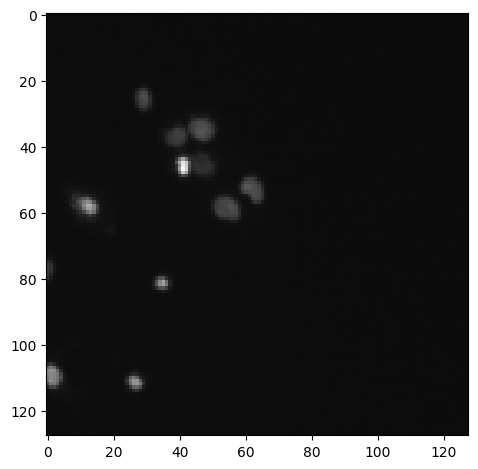

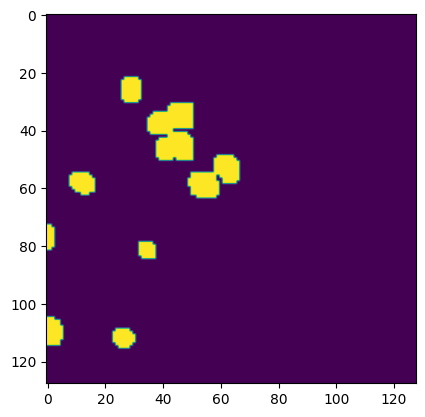

In [14]:
import random
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
plt.imshow(np.squeeze(Y_train[image_x]))

In [33]:
modelUNet = unet((128, 128, 3))
#checkpointer = tf.keras.callbacks.ModelCheckpoint("modelUnet.h5", verbose=1, save_best_only=True)
callbacks=[
    #checkpointer,
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 23s 246ms/step - loss: 0.2739 - accuracy: 0.8977 - val_loss: 51.7057 - val_accuracy: 0.7597
Epoch 2/25
38/38 [==============================] - 9s 245ms/step - loss: 0.1802 - accuracy: 0.9355 - val_loss: 1.3579 - val_accuracy: 0.5815
Epoch 3/25
38/38 [==============================] - 9s 239ms/step - loss: 0.1352 - accuracy: 0.9519 - val_loss: 0.9744 - val_accuracy: 0.5978
Epoch 4/25
38/38 [==============================] - 9s 238ms/step - loss: 0.1234 - accuracy: 0.9558 - val_loss: 0.7026 - val_accuracy: 0.6190
Epoch 5/25
38/38 [==============================] - 9s 234ms/step - loss: 0.1125 - accuracy: 0.9583 - val_loss: 0.2158 - val_accuracy: 0.8970
Epoch 6/25
38/38 [==============================] - 9s 232ms/step - loss: 0.1044 - accuracy: 0.9612 - val_loss: 0.2635 - val_accuracy: 0.8547
Epoch 7/25
38/38 [==============================] - 9s 231ms/step - loss: 0.0991 - accuracy: 0.9621 - val_loss: 0.1335 - val_accuracy: 0.9558
Epoc

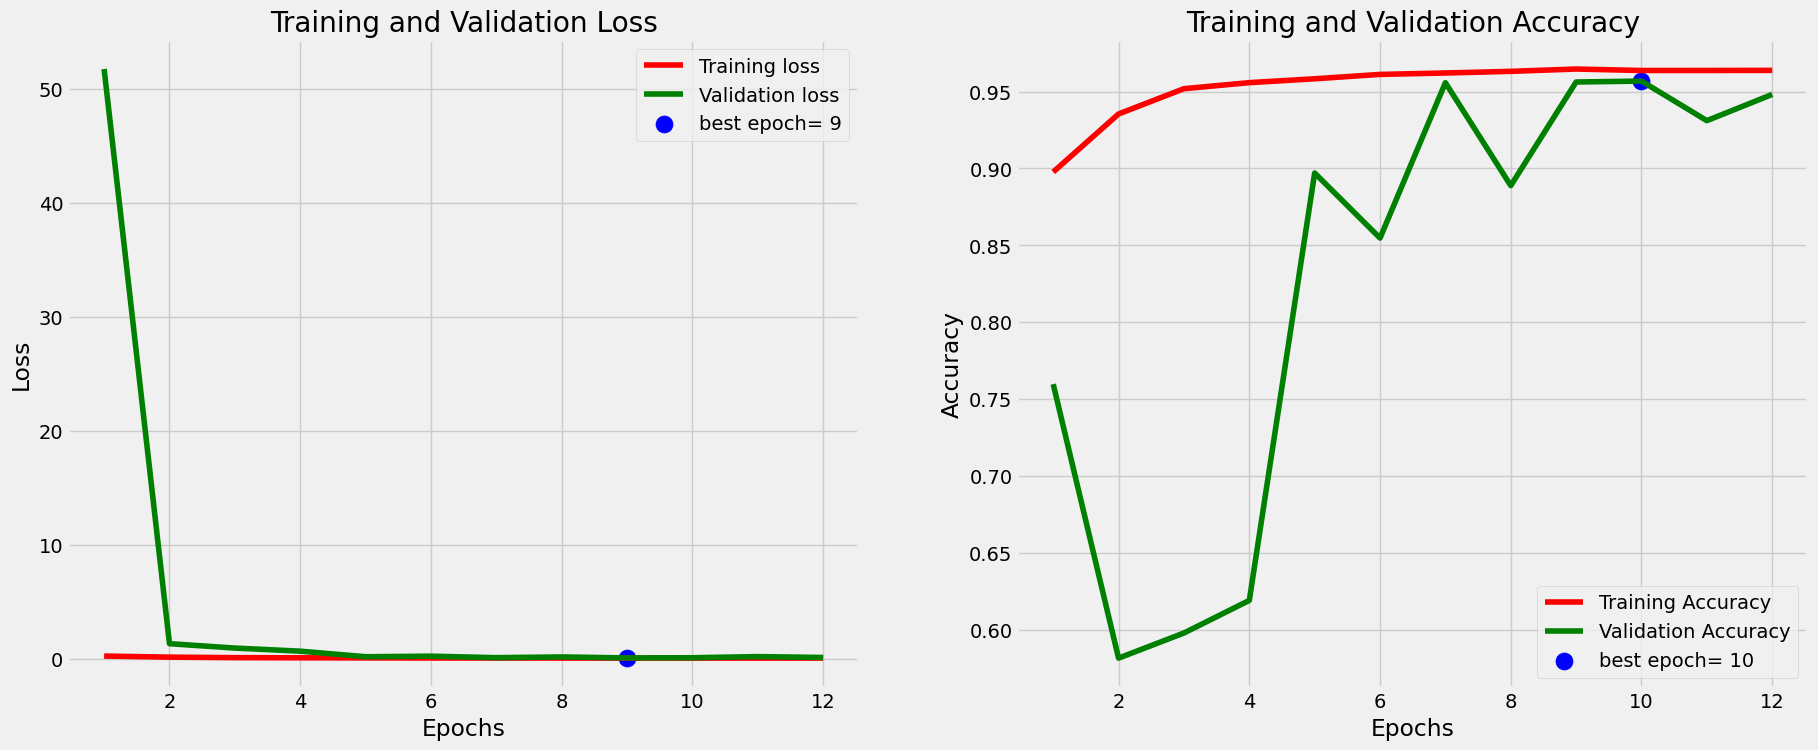

In [34]:
plot_training(results)

In [35]:
idx = random.randint(0, len(X_train))


preds_train = modelUNet.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = modelUNet.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = modelUNet.predict(X_test, verbose=1)

95/95 [==============================] - 13s 133ms/step


In [36]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

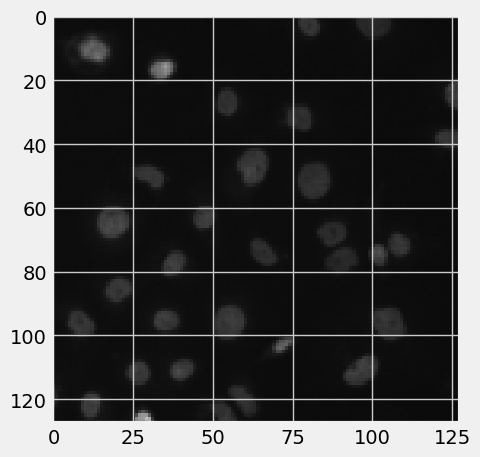

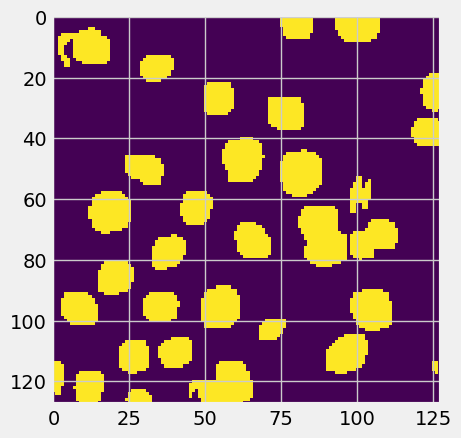

In [37]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
# plt.imshow(np.squeeze(Y_train[ix]))
plt.imshow(np.squeeze(preds_train_t[ix]))

In [38]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# RLE 알고리즘 인코딩 
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [39]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [40]:
# RLE 인코딩
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [41]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)